# Лабораторная работа по теме: "Подструктурный поиск"

In [1]:
from rdkit import Chem
from sklearn.metrics import pairwise_distances
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
import numpy as np
import pandas as pd
from itertools import product
from collections import defaultdict

# отключим предупреждения 
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

## <a name="substrSearch">Поиск по подструктуре</a>

#### Поиск по подструктуре, заданной SMARTS:

In [2]:
suppl = Chem.SDMolSupplier('data/data.sdf')
len(suppl)

100

In [3]:
# 1
patt = Chem.MolFromSmarts('c[NH1]')
matches = []
for mol in suppl:
    if mol.HasSubstructMatch(patt):
        matches.append(mol)

len(matches)

42

In [4]:
# 2
matches = [x for x in suppl if x.HasSubstructMatch(patt)]
print('Количество найденных молекул с требуемой подструктурой: ', len(matches))

Количество найденных молекул с требуемой подструктурой:  42


Выведем номера атомов, соответствующие трубуемой подструктуре, для одной молекулы: 

In [5]:
mol = Chem.MolFromSmiles('O1CCN(CC)CC1')
q = Chem.MolFromSmarts('CCN')
mol.HasSubstructMatch(q)

display(mol.GetSubstructMatch(q))
display(mol.GetSubstructMatches(q))

(1, 2, 3)

((1, 2, 3), (5, 4, 3), (7, 6, 3))

----

**Задание №1.** Напишите скрипт для поиска традиционных названий соединений, содержащих карбоксильную группу. Тривиальные названия приведены в виде свойства "Traditional Name" в файле data.sdf. Для их извлечения используйте функцию GetProp(). Используйте этот скрипт на файле data.sdf.

-----

In [50]:
def carboxyl_group(mol):
    carboxyl_pattern = Chem.MolFromSmarts("C(=O)O")  # SMARTS для карбоксильной группы
    return mol.HasSubstructMatch(carboxyl_pattern)

supplier = Chem.SDMolSupplier("data/data.sdf")

for mol in supplier:
    if carboxyl_group(mol): 
        traditional_name = mol.GetProp("Traditional Name")
        smiles = Chem.MolToSmiles(mol)  # Получаем SMILES представление
        print(f"Название: {traditional_name}, SMILES: {smiles}")

Название: ethyl (2E)-2-cyano-3-[(2-cyano-3-fluorophenyl)amino]prop-2-enoate, SMILES: CCOC(=O)/C(C#N)=C/Nc1cccc(F)c1C#N
Название: 1,3-diethyl 2-({[3-(methoxycarbonyl)phenyl]amino}methylidene)propanedioate, SMILES: CCOC(=O)C(=CNc1cccc(C(=O)OC)c1)C(=O)OCC
Название: (Z)-[amino({4-[2-nitro-4-(trifluoromethyl)phenoxy]phenyl})methylidene]amino 2-oxochromene-3-carboxylate, SMILES: N/C(=N\OC(=O)c1cc2ccccc2oc1=O)c1ccc(Oc2ccc(C(F)(F)F)cc2[N+](=O)[O-])cc1
Название: (E)-2-[1-(3-chlorobenzoyl)imidazol-2-yl]-1-(3-chlorophenyl)ethenyl 3-chlorobenzoate, SMILES: O=C(O/C(=C/c1nccn1C(=O)c1cccc(Cl)c1)c1cccc(Cl)c1)c1cccc(Cl)c1
Название: ethyl 6,8-difluoro-4-oxo-1H-quinoline-3-carboxylate, SMILES: CCOC(=O)c1c[nH]c2c(F)cc(F)cc2c1=O
Название: ethyl 5,7-dichloro-4-oxo-1H-quinoline-3-carboxylate, SMILES: CCOC(=O)c1c[nH]c2cc(Cl)cc(Cl)c2c1=O
Название: (1-methylpiperidin-4-ylidene)amino N-[3-(trifluoromethyl)phenyl]carbamate, SMILES: CN1CCC(=NOC(=O)Nc2cccc(C(F)(F)F)c2)CC1
Название: ethyl 1-(3-nitrothiophen-2-yl)pip

#### Поиск по подструктуре, заданной SMILES:

In [6]:
m = Chem.MolFromSmiles('C1=CC=CC=C1OC')
m.HasSubstructMatch(Chem.MolFromSmiles('COC'))

True

In [7]:
m.HasSubstructMatch(Chem.MolFromSmarts('COC'))

False

In [8]:
m.HasSubstructMatch(Chem.MolFromSmarts('COc'))

True

#### Учитываем стереохимию:

In [9]:
m = Chem.MolFromSmiles('CC[C@H](F)Cl')

In [10]:
m.HasSubstructMatch(Chem.MolFromSmiles('C[C@H](F)Cl'),useChirality=True)

True

In [11]:
m.HasSubstructMatch(Chem.MolFromSmiles('C[C@@H](F)Cl'),useChirality=True)

False

_внимание на поведение функции с аргументом useChirality=True и False и на молекуле с отмеченной стереохимией и без:_

In [12]:
m.HasSubstructMatch(Chem.MolFromSmiles('CC(F)Cl'))

True

In [13]:
m.HasSubstructMatch(Chem.MolFromSmiles('CC(F)Cl'),useChirality=True)

True

In [14]:
m2 = Chem.MolFromSmiles('CC(F)Cl')

In [15]:
m2.HasSubstructMatch(Chem.MolFromSmiles('C[C@H](F)Cl'),useChirality=True)

False

## <a name="duplSearch"> Поиск дубликатов</a>

### <a name="duplSearchInchi">с использованием InChI</a>

In [16]:
suppl = Chem.SDMolSupplier('data/data.sdf')

In [17]:
molecules = [x for x in suppl if x is not None]
for mol in molecules:
    mol.SetProp("InChI",Chem.MolToInchi(mol,options="-KET"))

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged; Omitted undefined stereo

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Omitted undefined stereo

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged

[17:45:52] WARNING: Charges were rearranged; Omitted undefined stereo

[17:45:52] WARNING: Charges were rearranged



In [18]:
from collections import defaultdict
counter = defaultdict(list)
for i, mol in enumerate(molecules):
    counter[mol.GetProp("InChI")].append(i)
result = sorted(counter.items(), key=lambda x: len(x[1]), reverse=True)
result

[('InChI=1/C13H16O2/c1-9(2)11-4-6-12(7-5-11)13(15)8-10(3)14/h4-7,9H,1-3H3,(H2,8,14,15)',
  [16, 75, 81]),
 ('InChI=1/C7H12O2/c1-5(2)7(9)4-6(3)8/h1-3H3,(H3,4,5,8,9)', [2, 66]),
 ('InChI=1/C11H12O2/c1-8-3-5-10(6-4-8)11(13)7-9(2)12/h3-6H,1-2H3,(H2,7,12,13)',
  [7, 90]),
 ('InChI=1/C9H16O2/c1-7(10)5-8(11)6-9(2,3)4/h1-4H3,(H4,5,6,10,11)', [13, 49]),
 ('InChI=1/C10H10O2/c1-8(11)7-10(12)9-5-3-2-4-6-9/h2-6H,1H3,(H2,7,11,12)',
  [18, 25]),
 ('InChI=1/C8H14O2/c1-6(2)4-8(10)5-7(3)9/h6H,1-3H3,(H4,4,5,9,10)', [34, 36]),
 ('InChI=1/C8H14O2/c1-6(9)5-7(10)8(2,3)4/h1-4H3,(H2,5,9,10)', [61, 74]),
 ('InChI=1/C5H8O2/c1-4(6)3-5(2)7/h1-2H3,(H2,3,6,7)', [72, 99]),
 ('InChI=1/C12H10FNO2/c1-7(2)6-10-14-9-5-3-4-8(13)11(9)12(15)16-10/h3-6H,1-2H3',
  [0]),
 ('InChI=1/C13H10FN3O2/c1-2-19-13(18)9(6-15)8-17-12-5-3-4-11(14)10(12)7-16/h3-5,8,17H,2H2,1H3/b9-8+',
  [1]),
 ('InChI=1/C24H15Cl2F2N3O3/c1-12-19(22(31-34-12)20-15(25)4-2-5-16(20)26)23(32)30-18-7-3-6-17(28)21(18)24(33)29-14-10-8-13(27)9-11-14/h2-11H,1H3,(H,29,3

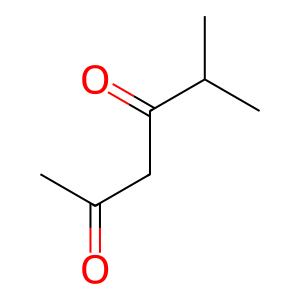

In [19]:
Draw.MolToImage(molecules[2], size=(300,300)) # , kekulize=True, wedgeBonds=True, \
                # fitImage=False, canvas=None)

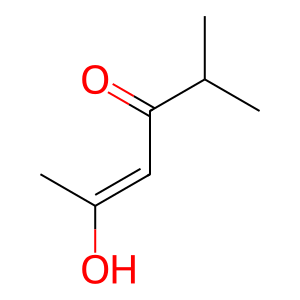

In [20]:
Draw.MolToImage(molecules[66], size=(300, 300))  # , kekulize=False, wedgeBonds=False, \
                # fitImage=True, options=None, canvas=None

### <a name="duplSearchCanSmiles">с использованием канонических SMILES</a>

In [21]:
for mol in molecules:
    mol.SetProp("SMILES",Chem.MolToSmiles(mol))
from collections import defaultdict
counter = defaultdict(list)
for i,mol in enumerate(molecules):
    counter[mol.GetProp("SMILES")].append(i)
result = sorted(counter.items(), key=lambda x:len(x[1]), reverse=True)
result

[('C/C(O)=C\\C(=O)c1ccc(C(C)C)cc1', [16, 75]),
 ('CC(C)=Cc1nc2cccc(F)c2c(=O)o1', [0]),
 ('CCOC(=O)/C(C#N)=C/Nc1cccc(F)c1C#N', [1]),
 ('CC(=O)CC(=O)C(C)C', [2]),
 ('Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)Nc1cccc(F)c1C(=O)Nc1ccc(F)cc1', [3]),
 ('O=c1oc(-c2cccc(C(F)(F)F)c2)nc2cccc(F)c12', [4]),
 ('O=C(CCC(=O)c1cccs1)c1cccs1', [5]),
 ('CCOC(=O)C(=CNc1cccc(C(=O)OC)c1)C(=O)OCC', [6]),
 ('CC(=O)CC(=O)c1ccc(C)cc1', [7]),
 ('CCOc1ccc2nc(NC(=O)c3ccc([N+](=O)[O-])o3)sc2c1', [8]),
 ('O=C(Nc1nc2ccccc2s1)c1ccc([N+](=O)[O-])o1', [9]),
 ('N/C(=N\\OC(=O)c1cc2ccccc2oc1=O)c1ccc(Oc2ccc(C(F)(F)F)cc2[N+](=O)[O-])cc1',
  [10]),
 ('O=C(O/C(=C/c1nccn1C(=O)c1cccc(Cl)c1)c1cccc(Cl)c1)c1cccc(Cl)c1', [11]),
 ('CCOC(=O)c1c[nH]c2c(F)cc(F)cc2c1=O', [12]),
 ('C/C(O)=C\\C(=O)CC(C)(C)C', [13]),
 ('CCOC(=O)c1c[nH]c2cc(Cl)cc(Cl)c2c1=O', [14]),
 ('CC(NC(=O)c1cc([N+](=O)[O-])cc2c1-c1ccc([N+](=O)[O-])cc1C2=O)c1ccccc1.O',
  [15]),
 ('COc1cc(Br)cc(/C=N/NC(=S)NC(C)(C)C)c1O', [17]),
 ('C/C(O)=C\\C(=O)c1ccccc1', [18]),
 ('Cc1c(Cl)cccc1NC(=

## <a name="standardization">Стандартизация</a>

При выполнении функции "чтения" молекулы по умолчанию выполняется операция «дезинфекции» (**sanitization**) данной молекулы. Идея состоит в том, чтобы генерировать полезные вычисляемые свойства (например, гибридизацию, участие в кольце и т. д.) для остальной части кода и гарантировать, что молекулы «разумны»: они могут быть представлены точечными структурами Льюиса.

Ниже представлены этапы обработки молекулы:
<ol><li>**_clearComputedProps_**: удаляет любые расчетные свойства, которые уже существуют для молекулы и ее атомов и связей. Этот шаг выполняется всегда.</li>
<li>**_cleanUp_**: стандартизирует некоторые нестандартные состояния валентности. 
Операции очистки:

<ul><li>           Нейтральные 5-валентные атомы N с двойными связями с атомами O преобразуются в цвиттерионную форму. Пример: N (= O) = O -> [N +] (= O) O-]</li>
               <li> Нейтральные 5-валентные атомы N с тройными связями с другими N преобразуются в цвиттерионную форму. Пример: C-N = N # N -> C-N = [N +] = [N-]</li>
                <li>Нейтральный 5-валентный фосфор с одной двойной связью с O и другой либо с C, либо с P преобразуется в цвиттерионную форму. Пример: C = P (= O) O -> C = [P +] ([O -]) O</li>
               <li> Нейтральный Cl, Br или I с исключительно O соседями и валентностью 3, 5 или 7 превращаются в цвиттерионную форму. Это включая такие вещества, как хлорная кислота, хлорная кислота и перхлорная кислота. Пример: O = Cl (= O) O -> [O -] [Cl + 2] [O-] O</li></ul>

        Этот шаг не должен генерировать исключения.</li>

<li>        **_updatePropertyCache_**: вычисляет явные и неявные валентности для всех атомов. Это порождает исключения для атомов в более высоких разрешенных валентных состояниях. Этот шаг всегда выполняется, но если он «пропущен», тест на нестандартные валентности не будет выполнен.</li>

<li>        **_symrizeSSSR_**: вызывает алгоритм наименьшего числа симметризованных алгоритмов наименьших колец.</li>

<li>        **_Kekulize_**: превращает ароматические кольца в их форму Кекуле. Возбуждает исключение, если кольцо не может быть подвергнуто преобразованию в форму Кекуле или если ароматические связи найдены вне колец.</li>

<li>        **_assignRadicals_**: определяет количество радикальных электронов (если они есть) на каждом атоме.</li>

<li>        **_setAromaticity_**: идентифицирует ароматические кольца и кольцевые системы, устанавливает ароматический флаг на атомах и связях, преобразует порядок связей в ароматический.</li>
<li>
        **_setConjugation_**: идентифицирует, какие связи конъюгированы</li>

<li>        **_setHybridization_**: вычисляет состояние гибридизации каждого атома</li>

<li>        **_cleanupChirality_**: удаляет хиральные метки из атомов, которые не находятся в состоянии sp3 гибридизации.</li>

<li>        **_adjustHs_**: добавляет явные атомы водорода, где необходимо, например, для гетероатомов в ароматических кольцах. Классическим примером является атом азота в пирроле.</li></ol>

Отдельные шаги можно включать или отключать при вызове **_MolOps :: sanitizeMol_** или **_Chem.SanitizeMol_**.

## <a name="similarity">Расчет и сравнение метрик сходства</a>

#### Расчет молекулярных отпечатков

##### Топологические молекулярные отпечатки

Топологические молекулярные отпечатки представляют собой топологические пути между парами атомов, находящимися на определенном расстоянии друг от друга (по умолчанию: min 1, max 7).


In [22]:
mol1 = molecules[0]
mol2 = molecules[1]

In [23]:
fp1 = FingerprintMols.FingerprintMol(mol1)
fp2 = FingerprintMols.FingerprintMol(mol2)

In [24]:
fp1

In [25]:
DataStructs.FingerprintSimilarity(fp1, fp2)

0.3826530612244898

In [26]:
DataStructs.FingerprintSimilarity(fp1,fp2, metric=DataStructs.DiceSimilarity)

0.5535055350553506

По умолчанию для рассчета используется индекс Танимото, однако имеется возможность использовать и некоторые другие индексы, перечисленные ниже:
<ul><li>Индекс Танимото -  TanimotoSimilarity (именно индекс,а не метрика, т.е. отражает сходство (близость))</li>
<li>Индекс Дайса - DiceSimilarity</li>
<li>Индекс косинуса - CosineSimilarity</li>
<li>"Sokal" - SokalSimilarity</li>
<li>"Russel" - RusselSimilarity</li>
<li>"RogotGoldberg" - RogotGoldbergSimilarity</li>
<li>"AllBit" - AllBitSimilarity</li>
<li>"Kulczynski" - KulczynskiSimilarity</li>
<li>"McConnaughey" - McConnaugheySimilarity</li>
<li>"Asymmetric" - AsymmetricSimilarity</li>
<li>"BraunBlanquet" - BraunBlanquetSimilarity</li>
</ul>

##### MACCS keys

MACCS keys представляют собой SMARTS паттерны различных функциональных групп и общих фрагментов.

In [27]:
mol1 = Chem.MolFromSmiles("ClC1=CC=CC=C1")
mol2 = Chem.MolFromSmiles("BrC1=CC=CC=C1")
fp1 = MACCSkeys.GenMACCSKeys(mol1)
fp2 = MACCSkeys.GenMACCSKeys(mol2)

In [28]:
fp1

In [29]:
DataStructs.FingerprintSimilarity(fp1, fp2)

0.75

#### Morgan fingerprints (Circular Fingerprints)

Это семейство молекулярных отпечатков, более известных как круговые молекулярные отпечатки, построено путем применения алгоритма Моргана к набору пользовательских инвариантов атомов. При создании молекулярных отпечатков Моргана необходимо также указать радиус молекулярного отпечатка:

In [30]:
fp1 = AllChem.GetMorganFingerprint(mol1, 1)
fp2 = AllChem.GetMorganFingerprint(mol2, 1)

[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator


Молекулярные отпечатки Моргана представляют собой счетчики (counts), таким образом, в качестве метрики должен использоваться индекс Дайса:

In [31]:
DataStructs.DiceSimilarity(fp1, fp2)

0.7857142857142857

Однако молекулярные отпечатки Моргана можно рассчитать и в виде битовых векторов:

In [32]:
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)

[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator


In [33]:
DataStructs.DiceSimilarity(fp1,fp2)

0.5454545454545454

In [34]:
DataStructs.FingerprintSimilarity(fp1, fp2)

0.375

В случае, если дескрипторы планируется использовать для вычисления, к примеру, индексов сходства с помощью других библиотек, необходимо превратить объекты RDkit в обычные numpy array:

Превратим битовые вектора молекулярных отпечатков Моргана в numpy array:

In [35]:
fps_bit = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in molecules[:5]]
np_fps = []
for fp in fps_bit:
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)
np_fps = np.array(np_fps)

[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator


In [36]:
np_fps

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

Для случаев, когда молекулярные отпечатки Моргана представляют собой счетчики (counts):

In [37]:
fps = [AllChem.GetHashedMorganFingerprint(x, 2, nBits=1024) for x in molecules[:5]]
np_fps_count = []
for fp in fps:
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps_count.append(arr)
np_fps_count = np.array(np_fps_count)

[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator
[17:45:53] DEPRECATION WARNING: please use MorganGenerator


In [38]:
np_fps_count

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

### Использование метрик сходства и различия

In [39]:
tanimoto_dict = defaultdict(list)  # создадим словарь списков индексов сходства молекул
index_list = [f'mol{k}' for k in range(1,6,1)]
i = 1
k = 1
for mol1, mol2 in product(fps_bit, fps_bit):
    tanimoto_dict[f'mol{k}'].append(DataStructs.FingerprintSimilarity(mol1, mol2))
    if i % 5 == 0:
        k += 1
    i += 1
a = pd.DataFrame.from_dict(tanimoto_dict, orient='index', columns=index_list)
print(a)  # получили DataFrame индексов Танимото, вычисленных для всех пар молекул

          mol1      mol2      mol3      mol4      mol5
mol1  1.000000  0.206349  0.086957  0.202899  0.460000
mol2  0.206349  1.000000  0.115385  0.229730  0.140845
mol3  0.086957  0.115385  1.000000  0.083333  0.018519
mol4  0.202899  0.229730  0.083333  1.000000  0.157895
mol5  0.460000  0.140845  0.018519  0.157895  1.000000


Визуализируем полученные результаты, построив heatmap.  
Самый простой способ построить heatmap - использовать библиотеку seaborn [http://seaborn.pydata.org/generated/seaborn.heatmap.html, https://habr.com/ru/company/ods/blog/323210/, https://python-scripts.com/matplotlib ].

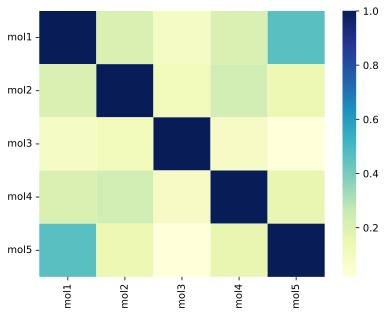

In [40]:
ax = sns.heatmap(a, cmap='YlGnBu')

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.savefig('seabornPandas.png', dpi=100)
plt.show()

Выбор представленных в RDkit метрик сходства и различия не так уж и широк.  
Соответственно, стоит использовать и другие библиотеки, в которых представлены метрики сходства и различия. Например, [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) (по ссылке представлен список доступных дескрипторов). 

In [41]:
array_dif = pairwise_distances(np_fps, np_fps, metric='jaccard')

In [42]:
array_dif

array([[0.        , 0.79365079, 0.91304348, 0.79710145, 0.54      ],
       [0.79365079, 0.        , 0.88461538, 0.77027027, 0.85915493],
       [0.91304348, 0.88461538, 0.        , 0.91666667, 0.98148148],
       [0.79710145, 0.77027027, 0.91666667, 0.        , 0.84210526],
       [0.54      , 0.85915493, 0.98148148, 0.84210526, 0.        ]])

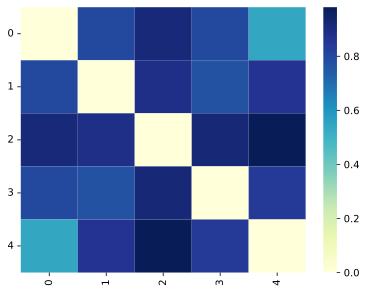

In [43]:
ax = sns.heatmap(array_dif, cmap='YlGnBu')

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.show()

--------------

# Домашнее задание 


Используя нижеперечисленные индексы сходства и различия, постройте heatmapы для всех молекул из data.sdf: индекс Танимото, индекс Дайса и индекс косинуса из RDkit и манхэттэнское расстояние, евклидово расстояние, индекс Жаккарда, индекс Дайса из scikit-learn. В качестве дескрипторов используйте Morgan fingerprints из RDkit. Обратите внимание на требования к дескрипторам при вычислении индексов (битовый вектор? численные дескрипторы?). Сравните полученные heatmapы. Сделайте выводы. Опишите в отчете.

In [ ]:
def similarity_matrix(fps, metric):
    n = len(fps)
    sim_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            if metric == "Tanimoto":
            sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim  # Матрица симметрична
    return sim_matrix

# Отдельная функция для вычисления косинусного сходства
def cosine_matrix(fps):
    n = len(fps)
    sim_matrix = np.zeros((n, n))
    
    for i in range(n):
        similarities = DataStructs.BulkCosineSimilarity(fps[i], fps)
        sim_matrix[i, :] = similarities
    
    return sim_matrix

def heatmap(matrix, title, filename):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap="coolwarm", annot=False, square=True)
    plt.title(title)
    plt.savefig(filename)
    plt.close()
supplier = Chem.SDMolSupplier("data/data.sdf")

fingerprints = []

count = 0
for mol in supplier:
    if count > 10: # возьмем первые 10 молекул для читаемости
        break
    if mol is not None:
        count += 1
        fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048))


sim_matrix = similarity_matrix(fingerprints, "Tanimoto")
heatmap(sim_matrix, f"Similarity Heatmap ({metric})", f"{metric}_heatmap.png")


cos_matrix = cosine_matrix(fingerprints)
heatmap(cos_matrix, "Similarity Heatmap (Cosine)", "Cosine_heatmap.png")

[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator
[18:49:09] DEPRECATION WARNING: please use MorganGenerator


In [61]:
# биты в численные дескрипторы
fingerprints_array = np.array([np.array(list(fp)) for fp in fingerprints])
sklearn_metrics = {
    "Manhattan": "manhattan",
    "Euclidean": "euclidean",
    "Jaccard": "jaccard",
    "Dice": "dice",
}

for metric_name, sklearn_metric in sklearn_metrics.items():
    dist_matrix = pairwise_distances(fingerprints_array, metric=sklearn_metric)
    
    # Для сходства используем инверсию расстояния (1 - расстояние)
    if sklearn_metric in ["jaccard", "dice"]:
        sim_matrix = 1 - dist_matrix
    else:
        sim_matrix = dist_matrix
    
    heatmap(sim_matrix, f"Similarity Heatmap ({metric_name})", f"{metric_name}_heatmap.png")